In [41]:
from numpy import *
from scipy import *
import numpy as np

from scipy import integrate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd

In [2]:
def Properties(SpecHeat,dTad,B_l_int,B_h_int,T,N_ml): #Get the properties on the low and high field

    C_l = zeros([N_ml,len(T)])
    C_h = zeros([N_ml,len(T)])
    dT_l = zeros([N_ml,len(T)])
    dT_h = zeros([N_ml,len(T)])
    

    for i in range(K):
        if B_exp[i] == B_l_int:
            for j in range(N_ml):
                C_l[j][i]=C[j,i]
                dT_l[j][i]=dT[j,i]

        if B_exp[i] == B_h_int and B_exp[i-1]< B_h_int:
            A = i
        if B_exp[i] == B_h_int:
            for j in range(N_ml):
                C_h[j][i-A]=C[j,i]
                dT_h[j][i-A]=dT[j,i]
                
    return(C_l,C_h,dT_l,dT_h)

In [3]:
def SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d):

    Th = 312
    Tc = 282

    C_mag = []
    C_dmag = []
    dT_mag = []
    dT_dmag = []

    T_int = np.arange(Tc,Th+0.01,0.1)


    #T_layer = np.arange(282,310.1,30/(15))
    #L_layer = (100/len(T_layer))*ones(len(T_layer))
    N_l = len(T_layer)

    A = np.int((Tc - min(T_exp))/0.1)



    T_t = []
    L = 0

    for i in range(N_l):
        L = L + L_layer[i]
        T_tr = Tc + 0.001 +L/100*(Th-Tc)
        T_t.append(T_tr)

    k = 0    
    for i in range (len(T_int)):
        #print(T_int[i])
        if T_int[i] <=T_t[k]:
            #print(T_int[i],T_t[k])
            for j in range(len(T_l)):
                #print(T_layer[k],T_l[j])
                if T_layer[k] >= T_l[j] and T_layer[k] < T_l[j+1]:
                    #print('Hello')
                    #print(T_int[i],T_t[k],T_layer[k],T_l[j],T_l[j+1])
                    C_mag.append(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j+1][int(i+A)]-(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j+1][int(i+A)]-(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j+1][int(i+A)]-(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
        else:
            for j in range(len(T_l)):
                if T_layer[k+1] >= T_l[j] and T_layer[k+1] < T_l[j+1]:
                    C_mag.append(C_h[j][int(i+A)]+(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j][int(i+A)]+(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j][int(i+A)]+(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j][int(i+A)]+(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    #print(T_int[i],C_h[j+1][int(i+A)],C_h[j][int(i+A)],T_l[j+1],T_l[j],T_layer[k],(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j])))
            k = k + 1
            
    return (C_mag,C_dmag,dT_mag,dT_dmag)

In [4]:
def Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int):
    C_mag_mean   = integrate.simps(C_mag,T_int)/(max(T_int)-min(T_int))
    C_dmag_mean  = integrate.simps(C_dmag,T_int)/(max(T_int)-min(T_int))
    
    dT_mag_mean  = integrate.simps(dT_mag,T_int)/(max(T_int)-min(T_int))
    dT_dmag_mean = integrate.simps(dT_dmag,T_int)/(max(T_int)-min(T_int))
    
    CdT_mag_mean   = integrate.simps(np.array(C_mag)*np.array(dT_mag),T_int)/(max(T_int)-min(T_int))
    CdT_dmag_mean  = integrate.simps(np.array(C_dmag)*np.array(dT_dmag),T_int)/(max(T_int)-min(T_int))
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

In [5]:
def Metrics (SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml,Th,Tc,T_l,T_layer,L_layer):
    (C_l,C_h,dT_l,dT_h) = Properties(SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml) #Properties of low and high fields
    dT_ad = np.array(dT_h)-np.array(dT_l)
             
    T_dem = zeros([N_ml,len(T_arg)])
    for j in range(N_ml):
        T_dem[j] = T_arg + dT_ad[j]
             
    dT_ad_d = np.zeros([N_ml,len(T_arg)])
    for i in range(N_ml):
        for j in range(len(T_arg)):
            for k in range(len(T_dem[i])):
                if  T_arg[j] > T_dem[i][k] and T_arg[j] <= T_dem[i][k+1]:
                    dT_ad_d[i][j] = (dT_ad[i][k] + (T_arg[j] - T_dem[i][k])*(dT_ad[i][k+1]-dT_ad[i][k])/(T_arg[k+1]-T_arg[k]))

    (C_mag,C_dmag,dT_mag,dT_dmag) = SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)
    
    T_int = np.arange(Tc,Th+0.01,0.1)
    
    C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean = Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int)
    
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

Constant inputs

In [6]:
##Properties of the solid 

rho_s = 7900  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid

rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium
d_p = 500*10**(-6) #[m] Particle diameter
Epsilon = 0.45  #[-] Porosity

Properties Calculation

In [7]:
Prop = xlrd.open_workbook('La-Fe-Si.xlsx') #Import Properties File
SpecHeat = Prop.sheet_by_name('C') # #Import Specific Heat
dTad = Prop.sheet_by_name('dT') #Import Adiabatic Temperature Change

T_exp = dTad.col_values(0) #Import experimented temperatures 
B_exp = dTad.col_values(1) #Import experimented magnetic fields

T_arg = arange(min(T_exp),max(T_exp)+0.01,0.1)

K = len(dTad.col_values(0)) #Import data number

T_l = arange(270,315,2)#ture of Curie of the multilayer
N_ml = len(T_l) #Number of Multilayer Layers



dT = zeros([N_ml,K])
C = zeros([N_ml,K])
for i in range(N_ml):
    dT[i,:] = (dTad.col_values(i+2))    #Data of Adiabatic Temperature change
    C[i,:] = (SpecHeat.col_values(i+2)) #Data of specific heat

In [8]:
T_layer = arange(283,313.1,30/14)
L_layer = 100/len(T_layer)*ones(len(T_layer))

Importing AMR simulation inputs

In [9]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3)) #Import temperature span [K]
T_h = array(Inputs.col_values(4)) #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7)) #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]

Calculation

In [10]:
#Porous medium
m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
Beta = (1-Epsilon)*6/d_p
v_s   = (m_f/3600)/(rho_f*W*H*10**-6) #Superficial velocity

#Dimensionless Numbers
Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
Pe = Re_dp*Pr_f

h_int = Nu*k_f/d_p

#Effective conduction
k_e_f = k_f*Epsilon #Fluid effective conduction


a_0 = exp(-1.084-6.778*(Epsilon-0.298))
f_0 = 0.8
k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

D_ = (k_f*rho_f/c_f)*0.75*Pe/2

k_s_eff = k_e_s
k_f_eff = k_e_f + rho_f*c_f*D_

In [11]:
C_H = zeros(len(L))
C_L = zeros(len(L))
dT_mg = zeros(len(L))
dT_dmg = zeros(len(L))
CdT_mg = zeros(len(L))
CdT_dmg = zeros(len(L))

In [12]:
for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Metrics (SpecHeat,dTad,0,B[i],T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer,L_layer)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Model Parameters

In [29]:
Pi_1 = k_s_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_2 = Epsilon/(1-Epsilon)*k_f_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_3 = W_p/(m_s*f*CdT_dmg)
Pi_4 = CdT_mg/CdT_dmg
Pi_5 = h_int*Beta/(f*rho_s*CdT_dmg) #dT_sf unknown
Pi_6 = ((m_f/3600)*c_f)/(m_s*C_L)
Pi_7 = (T_h-T_c)/(dT_dmg)

Pi_8 = Q_c/(m_s*f*CdT_dmg)
Pi_9 = Q_h/(m_s*f*CdT_dmg)

In [39]:
def fitting(X,a,b,c,d,e,f,g,h): 
    P1,P2,P3,P4,P5,P6,P7= X
    return (a*(P1**b)*(P2**0)*(P3**0)*(P4**0)*(P5**0)*(P6**0)*(P7**0))

In [343]:
def fitting(X,a,b,c,d): 
    P1,P2= X
    return ((a*(P1**b)+c*(P1*P2)**(d)))

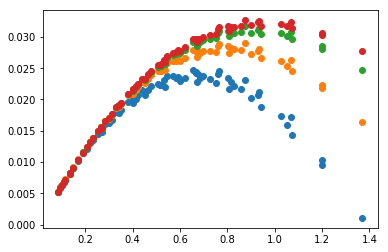

In [337]:
#plt.plot(Pi_6,Q_c,'o')
plt.plot(Pi_6[0:72],Pi_8[0:72],'o')
plt.plot(Pi_6[72:144],Pi_8[72:144],'o')
plt.plot(Pi_6[144:216],Pi_8[144:216],'o')
plt.plot(Pi_6[216:288],Pi_8[216:288],'o')

In [344]:
a = 0*72
b = 4*72

In [345]:
Coef = curve_fit(fitting,(Pi_6[a:b],Pi_4[a:b]),Pi_8[a:b],maxfev=10000)
Coef

(array([ 0.05304403, -0.08375493, -0.02342622, -0.37236813]),
 array([[ 0.02621506, -0.08426113, -0.02479204,  0.12716167],
        [-0.08426113,  0.2718741 ,  0.07969038, -0.40768248],
        [-0.02479204,  0.07969038,  0.02344637, -0.12025804],
        [ 0.12716167, -0.40768248, -0.12025804,  0.6179378 ]]))

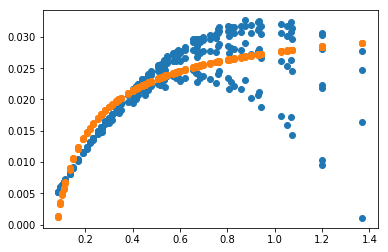

In [346]:
plt.plot(Pi_6[a:b],Pi_8[a:b],'o')
plt.plot(Pi_6[a:b],fitting((Pi_6[a:b],Pi_4[a:b]),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]),'o')

In [332]:
Cf=[]
Cf.append(Coef[0])
Cf

[array([-4.76204752,  1.39354378,  4.78042105,  1.38147529])]

In [263]:
a = 3
erro.append(abs(Pi_8[a*72:(a+1)*72]-fitting((Pi_6[a*72:(a+1)*72]),Cf[a][0],Cf[a][1],Cf[a][2])/Pi_8[a*72:(a+1)*72]*100))

In [284]:
erro1 = abs((Pi_8 -fitting((Pi_6,Pi_7),Coef[0][0],Coef[0][1],Coef[0][2]))/Pi_8*100)

(0, 25)

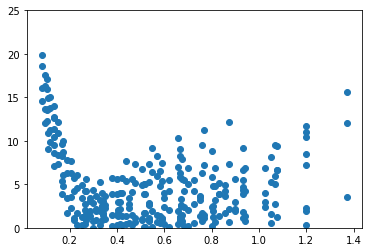

In [288]:
plt.plot(Pi_6,erro1,'o')
plt.ylim([0,25])

In [303]:
j = 0
for i in range(len(erro1)):
    if erro1[i] > 12:
        j=j+1
(j/len(erro1))*100

8.333333333333332

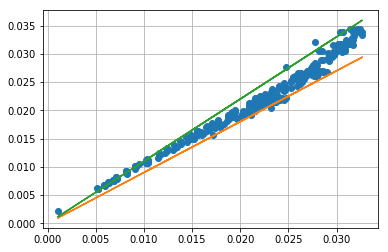

In [294]:
plt.plot(Pi_8,fitting((Pi_6,Pi_7),Coef[0][0],Coef[0][1],Coef[0][2]),'o')
plt.plot(Pi_8,0.9*Pi_8)
plt.plot(Pi_8,1.1*Pi_8)
plt.grid()

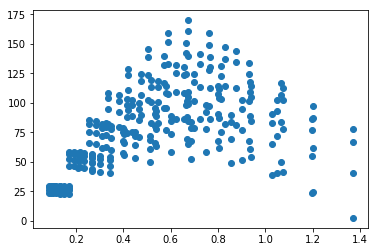

In [296]:
plt.plot(Pi_6,Q_c,'o')

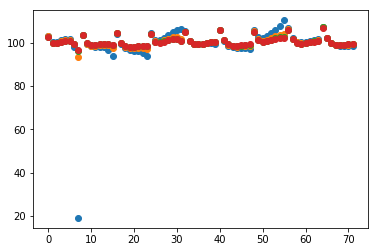

In [264]:
plt.plot(erro[0],'o')
plt.plot(erro[1],'o')
plt.plot(erro[2],'o')
plt.plot(erro[3],'o')